In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import decoupler as dc
import sys
import ast
import functools
import neptune

In [15]:
working_dir = '/home/acollin/scPermut/'
fig_dir = '/home/acollin/scPermut/analysis_notebooks/figures/'

In [16]:
import os
os.chdir(working_dir)

In [17]:
sys.path.append(working_dir)

In [18]:
from scpermut.tools.clust_compute import nn_overlap, batch_entropy_mixing_score,lisi_avg, balanced_matthews_corrcoef, balanced_f1_score, balanced_cohen_kappa_score

from sklearn.metrics import accuracy_score,balanced_accuracy_score,matthews_corrcoef, f1_score,cohen_kappa_score, adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score,davies_bouldin_score,adjusted_rand_score,confusion_matrix
f1_score = functools.partial(f1_score, average = 'macro')


In [19]:
from scpermut.workflow.dataset import load_dataset
from scpermut.tools.utils import ann_subset, check_raw,save_json, load_json, rgb2hex,hex2rgb

In [20]:
def load_run_df(task):
    project = neptune.init_project(
            project="becavin-lab/benchmark",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
        mode="read-only",
            )# For checkpoint

    runs_table_df = project.fetch_runs_table(query = f'`parameters/task`:string = "{task}"').to_pandas()
    project.stop()

    f =  lambda x : x.replace('evaluation/', '').replace('parameters/', '').replace('/', '_')
    runs_table_df.columns = np.array(list(map(f, runs_table_df.columns)))
    return runs_table_df

In [21]:
dataset_names = {'htap':'htap',
                "ajrccm_by_batch":"ajrccm_by_batch",
                'hlca_par_dataset_harmonized':'hlca_par_dataset_harmonized',
                'hlca_trac_dataset_harmonized':'hlca_trac_dataset_harmonized' ,
                'koenig_2022' : 'celltypist_dataset/koenig_2022/koenig_2022_healthy',
                'tosti_2021' : 'celltypist_dataset/tosti_2021/tosti_2021',
                'yoshida_2021' : 'celltypist_dataset/yoshida_2021/yoshida_2021',
                'tran_2021' : 'celltypist_dataset/tran_2021/tran_2021',
                'dominguez_2022_lymph' : 'celltypist_dataset/dominguez_2022/dominguez_2022_lymph',
                'dominguez_2022_spleen' : 'celltypist_dataset/dominguez_2022/dominguez_2022_spleen',
                'tabula_2022_spleen' : 'celltypist_dataset/tabula_2022/tabula_2022_spleen',
                'litvinukova_2020' : 'celltypist_dataset/litvinukova_2020/litvinukova_2020',
                 'lake_2021': 'celltypist_dataset/lake_2021/lake_2021'
                }

dataset_list = ['htap', 'yoshida_2021', 'hlca_trac_dataset_harmonized',
               'lake_2021', 'dominguez_2022_spleen', 'ajrccm_by_batch',
               'tosti_2021', 'tran_2021', 'litvinukova_2020','koenig_2022',
               'hlca_par_dataset_harmonized', 'dominguez_2022_lymph',
                'tabula_2022_spleen']


diff_dict = {'homo': ['tosti_2021', 'tran_2021', 'yoshida_2021', 'htap', 'ajrccm_by_batch'],
           'assays': ['dominguez_2022_lymph', 'dominguez_2022_spleen', 'tabula_2022_spleen'],
           'suspension': ['koenig_2022', 'litvinukova_2020', 'lake_2021'],
           'datasets': ['hlca_par_dataset_harmonized','hlca_trac_dataset_harmonized']}

aestetic_data_name = {'tosti_2021': 'Tosti 2021',
                      'tran_2021': 'Tran 2021', 
                      'yoshida_2021': 'Yoshida 2021',
                      'htap': 'Mbouamboua 2024', 
                      'ajrccm_by_batch': 'Deprez 2020',
                      'dominguez_2022_lymph': 'Dominguez 2022 - lymph',
                      'dominguez_2022_spleen': 'Dominguez 2022 - spleen',
                      'tabula_2022_spleen': 'Tabula Sapiens - spleen',
                      'koenig_2022': 'Koenig 2022', 
                      'litvinukova_2020': 'Litvinukova 2020', 
                      'lake_2021': 'Lake 2021',
                      'hlca_par_dataset_harmonized': 'HLCA - Parenchyma',
                      'hlca_trac_dataset_harmonized': 'HLCA - Airway'}

aestetic_model_name = {'scPermut' : 'scMusketeers',
                       'scPermut_default' : 'scMusketeers - default',
                      'scanvi' : 'scANVI',
                       'uce' : 'UCE', 
                       'harmony_svm' : 'Harmony',
                      'pca_svm' : 'PCA',
                       'celltypist' : 'Celltypist',
                       'scmap_cells' : 'scmap - cells',
                       'scmap_cluster' : 'scmap - cluster'}

hp_list=['use_hvg',
'batch_size',
'clas_w',
'dann_w',
'rec_w',
'ae_bottleneck_activation',
         'clas_loss_name',
'size_factor',
'weight_decay',
'learning_rate',
'warmup_epoch',
'dropout',
'layer1',
'layer2',
'bottleneck',
        'training_scheme']



# Figure 5 - subset on fixed number of cells

In [11]:
runs_table_df = load_run_df('task_3')

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/becavin-lab/benchmark/


Fetching table...: 0 [00:00, ?/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/becavin-lab/benchmark/metadata


In [22]:
test_fold_selection = load_json(working_dir + 'experiment_script/benchmark/hp_test_folds')
test_obs = load_json(working_dir + 'experiment_script/benchmark/hp_test_obs')

In [23]:
runs_table_df.query("task == 'task_3'").query('model == "scPermut"')['dataset_name'].value_counts()

tabula_2022_spleen              60
dominguez_2022_lymph            60
koenig_2022                     56
litvinukova_2020                49
hlca_par_dataset_harmonized     36
hlca_trac_dataset_harmonized    30
ajrccm_by_batch                 30
htap                            30
tosti_2021                      30
lake_2021                       30
dominguez_2022_spleen           30
yoshida_2021                    30
tran_2021                       23
Name: dataset_name, dtype: int64

In [24]:
# Removing duplicates

drop_koe = runs_table_df.loc[(runs_table_df['debug_status'] != 'fixed_1') & (runs_table_df['dataset_name'] == 'koenig_2022') & (runs_table_df['model'] == 'scPermut')]
drop_tab = runs_table_df.loc[(runs_table_df['debug_status'] != 'fixed_1') & (runs_table_df['dataset_name'] == 'tabula_2022_spleen') & (runs_table_df['model'] == 'scPermut')]
drop_dom = runs_table_df.loc[(runs_table_df['debug_status'] != 'fixed_1') & (runs_table_df['dataset_name'] == 'dominguez_2022_lymph') & (runs_table_df['model'] == 'scPermut')]

drop_lit = runs_table_df.loc[(runs_table_df['debug_status'] == 'fixed_1') & (runs_table_df['dataset_name'] == 'litvinukova_2020') & (runs_table_df['model'] == 'scPermut')]
drop_par = runs_table_df.loc[(runs_table_df['debug_status'] == 'fixed_1') & (runs_table_df['dataset_name'] == 'hlca_par_dataset_harmonized') & (runs_table_df['model'] == 'scPermut')]




runs_table_df = runs_table_df.drop(drop_koe.index).drop(drop_tab.index).drop(drop_dom.index).drop(drop_lit.index).drop(drop_par.index)

In [25]:
runs_table_df.query("task == 'task_3'").query('model == "scPermut"')['dataset_name'].value_counts()

koenig_2022                     30
dominguez_2022_lymph            30
tabula_2022_spleen              30
litvinukova_2020                30
hlca_trac_dataset_harmonized    30
lake_2021                       30
ajrccm_by_batch                 30
htap                            30
tosti_2021                      30
yoshida_2021                    30
dominguez_2022_spleen           30
hlca_par_dataset_harmonized     25
tran_2021                       23
Name: dataset_name, dtype: int64

In [26]:
task_3 = runs_table_df.query("task == 'task_3'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}")

In [28]:
colors = {'scPermut':"#B15236",
          # 'scPermut_default' : "#B15240",
          'scanvi':"#C78C3B" ,
          'uce':"#D3A53C" ,
          'harmony_svm': "#5B9DC7",
          'pca_svm':"#264D74",
          # 'pca_knn':"#264D80",
          'celltypist': "#75BAD3",
          'scmap_cells':"#607F6A" ,
          'scmap_cluster':"#707C45"}

colors = {aestetic_model_name[k]: v for k, v in colors.items()}

col = [hex2rgb(i) for i in colors.values()]

In [39]:
aestetic_model_name = {'scPermut' : '1.scMusketeers',
                        'scanvi' : '2.scANVI',
                       'uce' : '3.UCE', 
                       'harmony_svm' : '4.Harmony',
                       'pca_svm' : '5.PCA',
                        'celltypist' : '6.Celltypist',
                       'scmap_cells' : '7.scmap - cells',
                       'scmap_cluster' : '8.scmap - cluster'}
colors = {
          'scPermut' : "#B15240",
          'scanvi':"#C78C3B" ,
          'uce':"#D3A53C" ,
          'harmony_svm': "#5B9DC7",
          'pca_svm':"#264D74",
          # 'pca_knn':"#264D80",
          'celltypist': "#75BAD3",
          'scmap_cells':"#607F6A" ,
          'scmap_cluster':"#707C45"}

colors = {aestetic_model_name[k]: v for k, v in colors.items()}

diff_dict
diff_dict = {'all12':['tosti_2021',
  # 'tran_2021', # Removing Tran
  'yoshida_2021',
  'htap',
  'ajrccm_by_batch', 
    'dominguez_2022_lymph',
  'dominguez_2022_spleen'],
'all22': ['tabula_2022_spleen',
                    'koenig_2022', 'litvinukova_2020', 'lake_2021',
                    'hlca_par_dataset_harmonized', 'hlca_trac_dataset_harmonized']}

## Figure 5, hue = n_keep - Black & White 

--------- all12 ---------
--------- all22 ---------


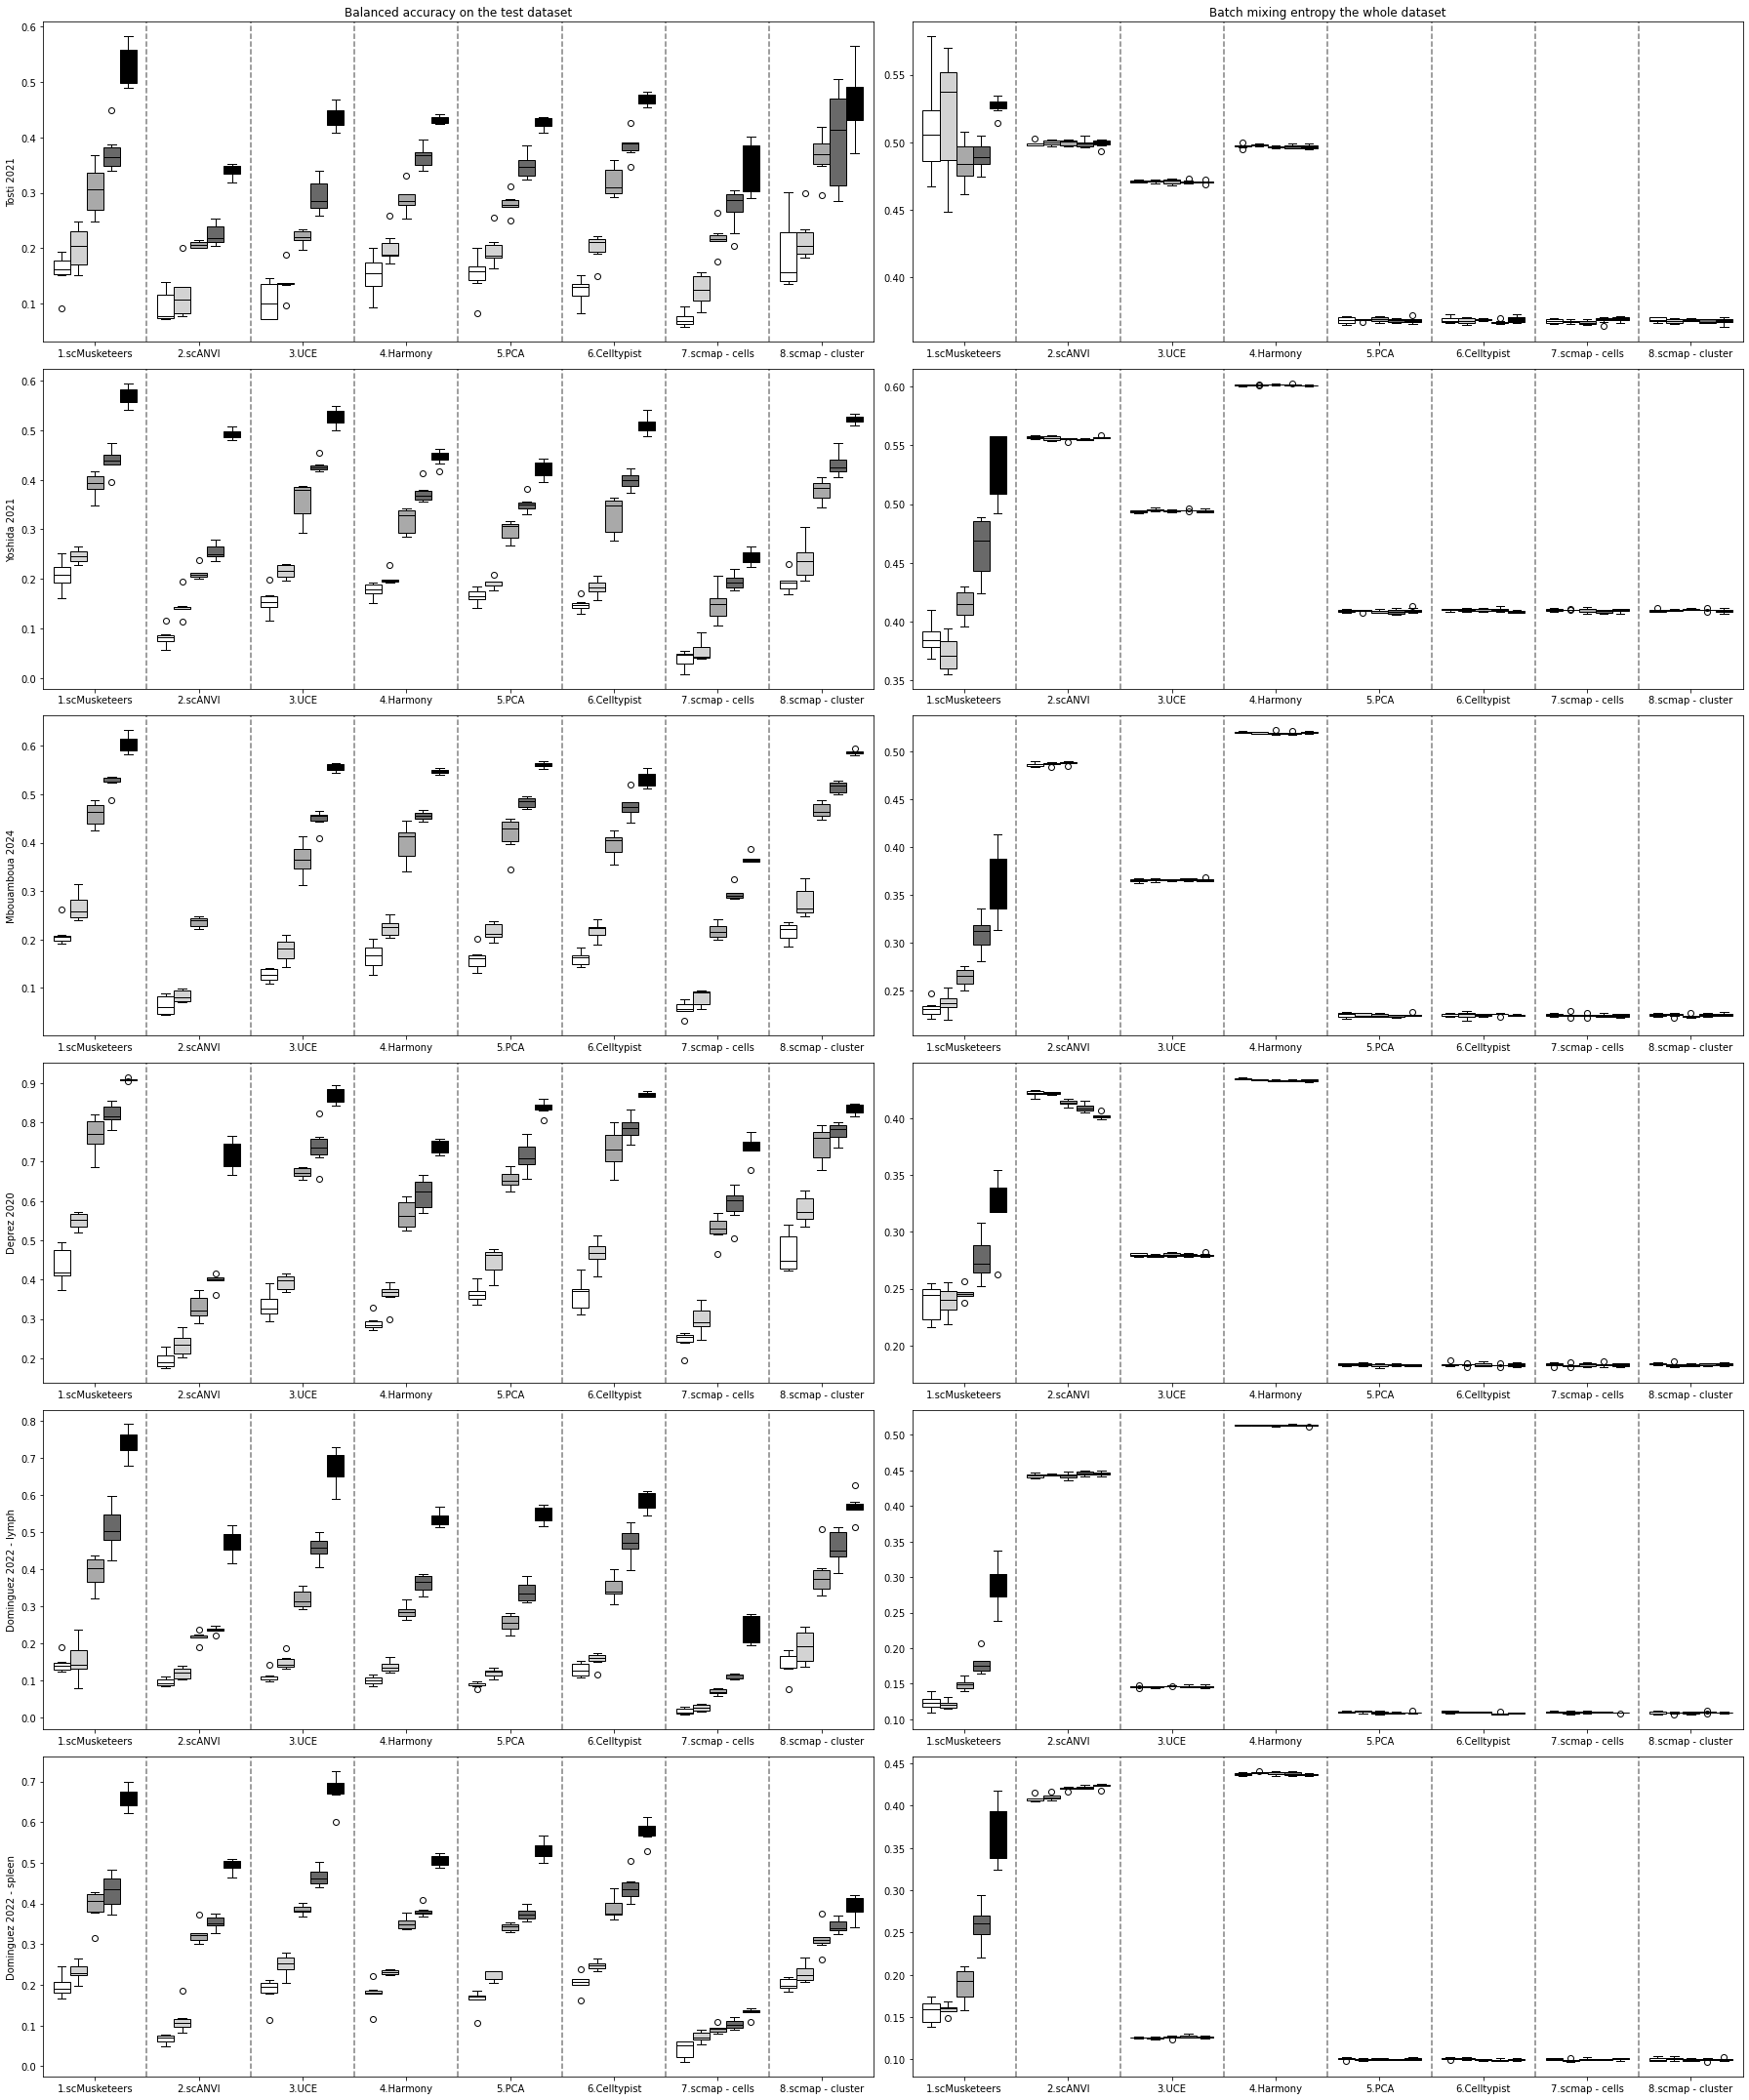

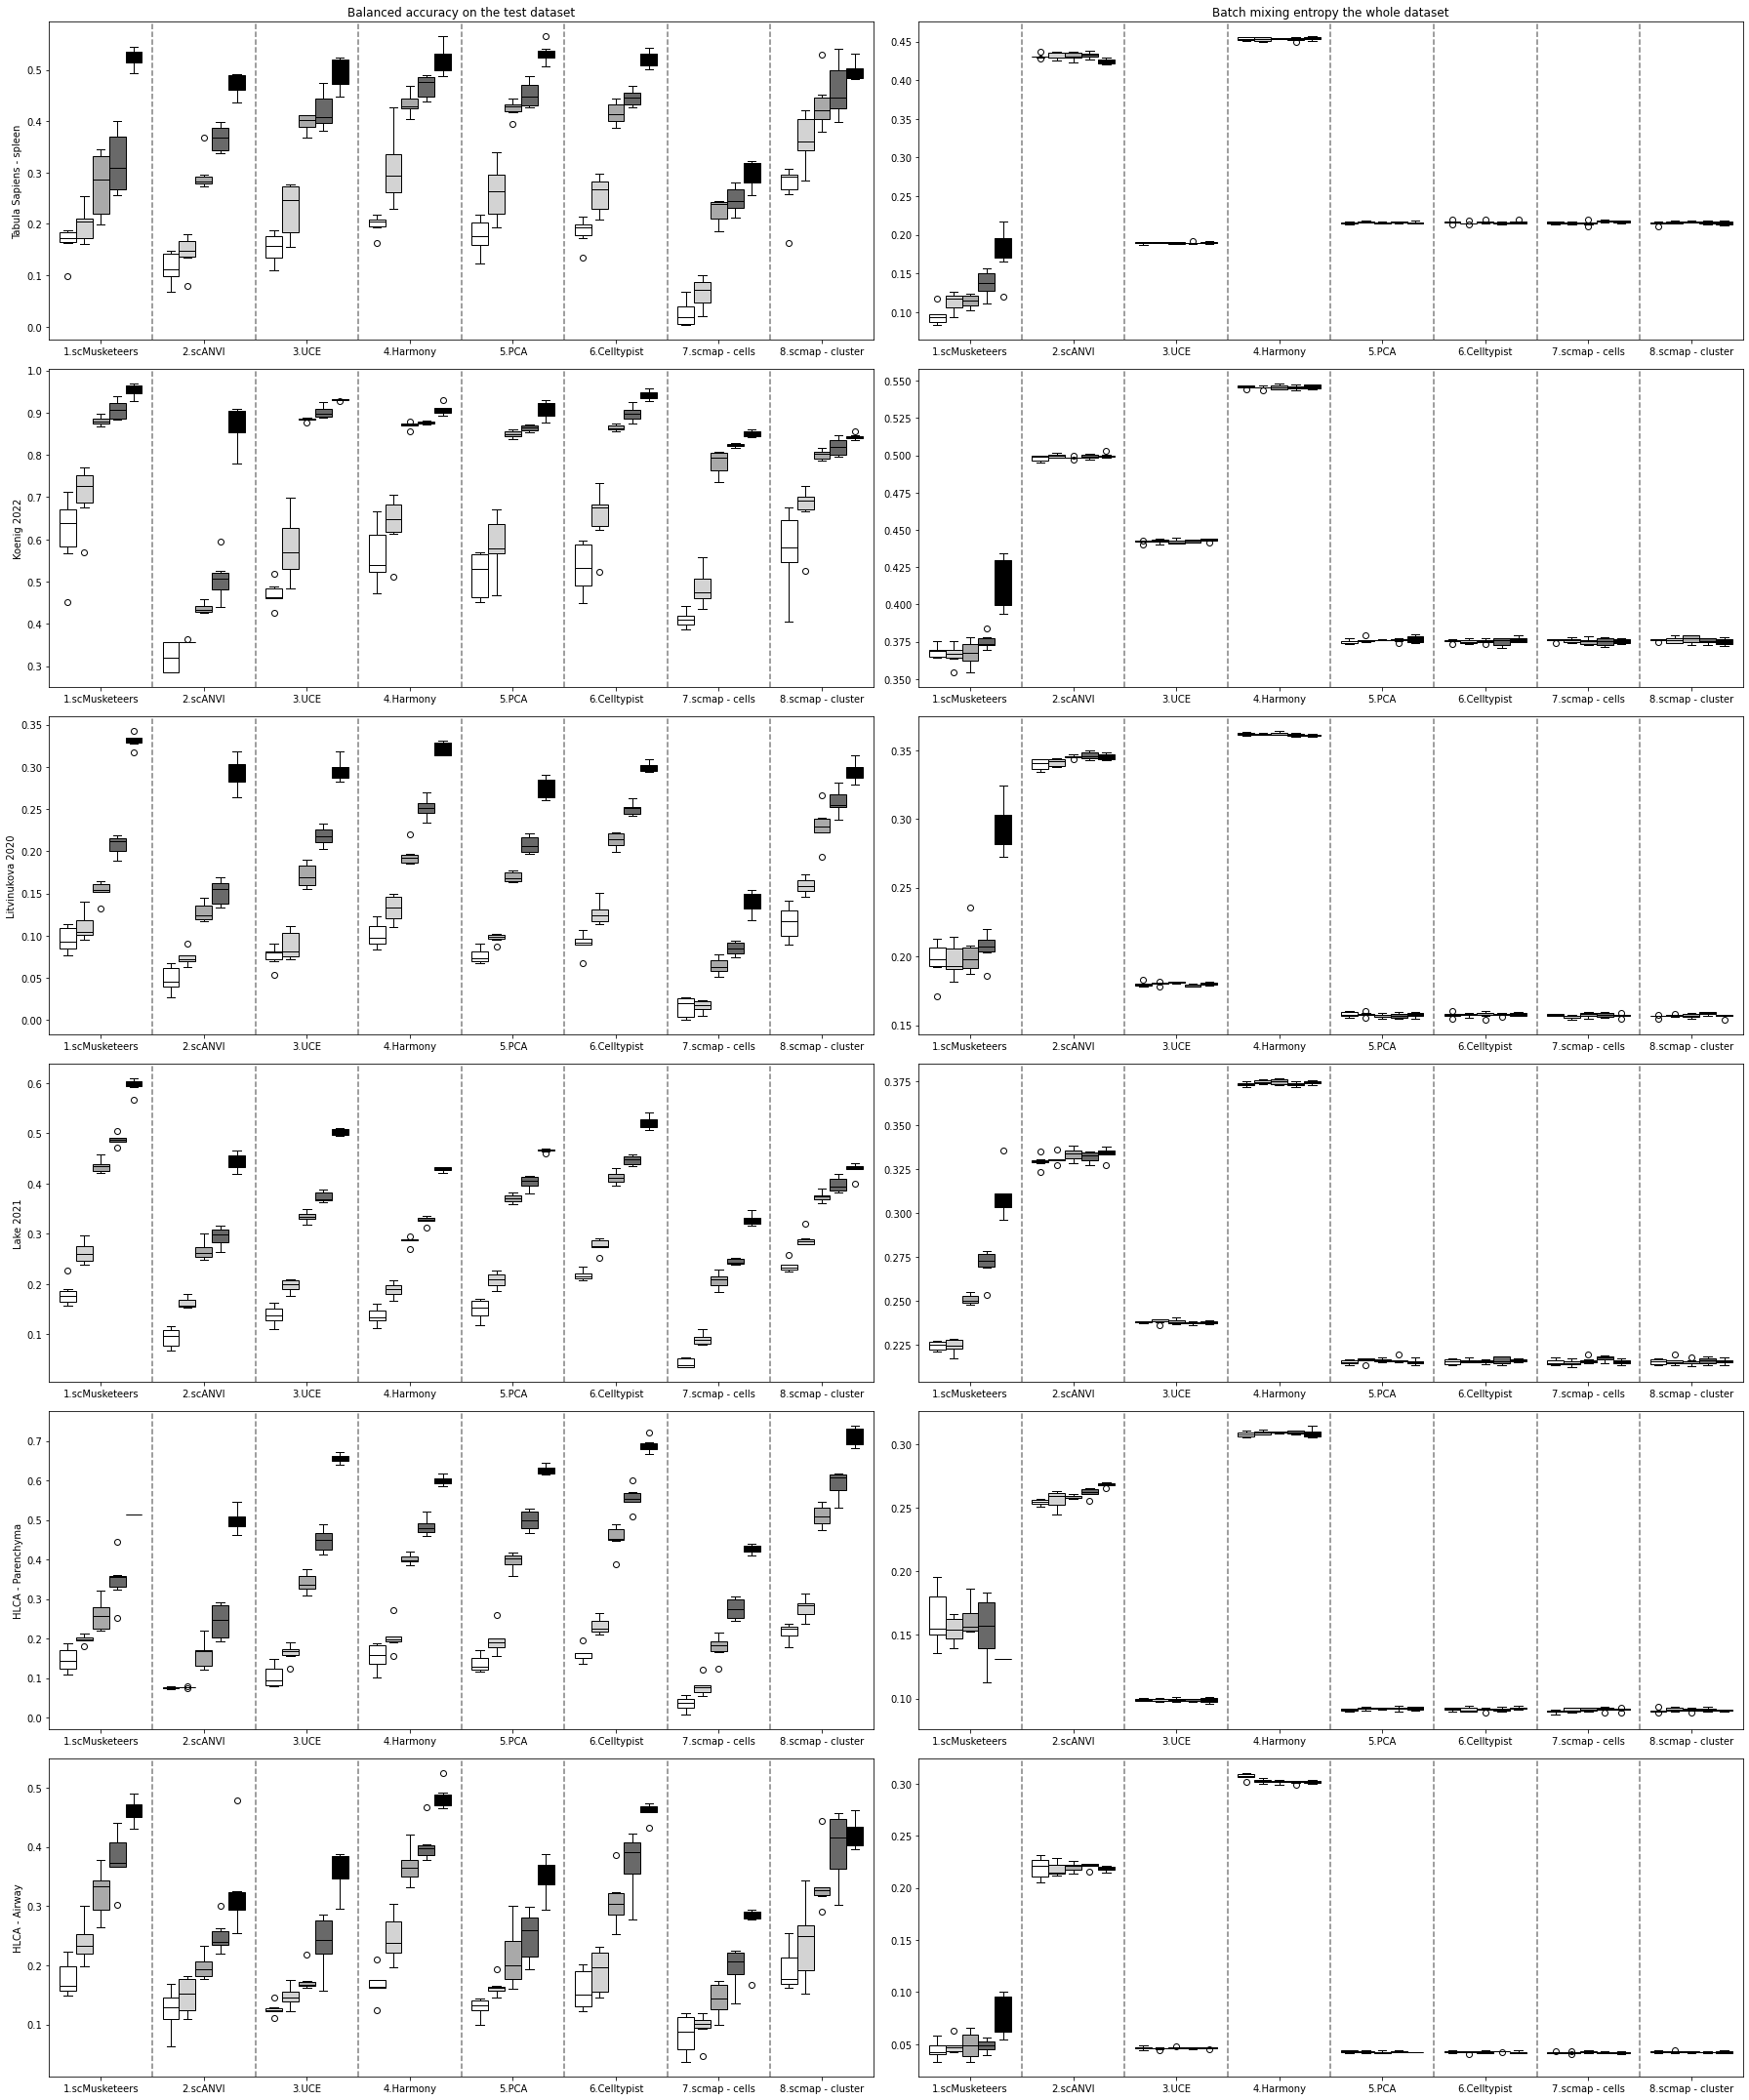

In [30]:
split = 'test'
met = 'balanced_acc'
# exclude_ds = ['tosti_2021', 'koenig_2022', 'litvinukova_2020','hlca_par_dataset_harmonized', 'hlca_trac_dataset_harmonized']
exclude_ds = []
show_legend = False
n_keep_colors = {'5':'white', '10':'lightgrey', '50':'darkgrey', '100': 'dimgrey', '500':'black'}

for diff in diff_dict:
    if diff != 'dataset':
        print(f'--------- {diff} ---------')
        n_lines = max(len([ i for i in diff_dict[diff] if i not in exclude_ds]),2)
        f, axes = plt.subplots(n_lines, 2, figsize = (25,5*n_lines))
        i=0
        for dataset_name in diff_dict[diff]:
            if dataset_name not in exclude_ds:
                
                task_3 = runs_table_df.query("task == 'task_3'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}")
                
                task_3['dataset_name'] =task_3['dataset_name'].replace(aestetic_data_name)
                task_3['model'] =task_3['model'].replace(aestetic_model_name)
        
                # task_3['model'] = pd.Categorical(task_3['model'], ['scPermut', 'scanvi', 'uce', 'pca_svm', 'harmony_svm', 'celltypist', 'scmap_cells', 'scmap_cluster']) 
                bplot1 = axes[i,0]
                bplot2 = axes[i,1]

                sns.boxplot(x = 'model' ,y =f'{split}_{met}', hue = 'n_keep', order = colors.keys(),
                            hue_order = [5,10,50,100,500] , data = task_3, ax = bplot1, palette = sns.color_palette(n_keep_colors.values()))

                for j in range(1, len(task_3['model'].unique())):
                    bplot1.axvline(x=j - 0.5, color='gray', linestyle='dashed', linewidth=1.5)
                    
                bplot1.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot1.set_title('Balanced accuracy on the test dataset')
                if i != n_lines:
                    bplot1.set_xlabel('')
                if i == n_lines:
                    bplot1.set_xlabel('Model')
                bplot1.set_ylabel(f'{aestetic_data_name[dataset_name]}') # - {diff} setup')

                task_3['model'] = task_3['model'].replace({'Celltypist': 'PCA',
                           'scmap - cells': 'PCA',
                           'scmap - cluster': 'PCA'})
                colors_BE = {k:v for k, v in colors.items() if k not in ['Celltypist','scmap - cells','scmap - cluster']}
                
                sns.boxplot(x = 'model',y =f'full_batch_mixing_entropy', hue = 'n_keep',
                            order = colors_BE.keys(), hue_order = [5,10,50,100,500], 
                            data = task_3, ax = bplot2, palette = sns.color_palette(n_keep_colors.values()))

                for j in range(1, len(task_3['model'].unique())):
                    bplot2.axvline(x=j - 0.5, color='gray', linestyle='dashed', linewidth=1.5)
                
                bplot2.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot2.set_title('Batch mixing entropy the whole dataset')
                if i != n_lines:
                    bplot2.set_xlabel('')
                if i == n_lines:
                    bplot2.set_xlabel('Model')
                bplot2.set_ylabel('')

                
                if not show_legend: 
                    bplot1.get_legend().set_visible(False)
                    bplot2.get_legend().set_visible(False)
                    
                # f.suptitle(f'{dataset_name} - {diff} setup')
                i+=1
                f.savefig(f'{fig_dir}task_3/prediction_boxplot_{diff}_BW.png', transparent=False)
                
                plt.tight_layout()

--------- all12 ---------
--------- all22 ---------


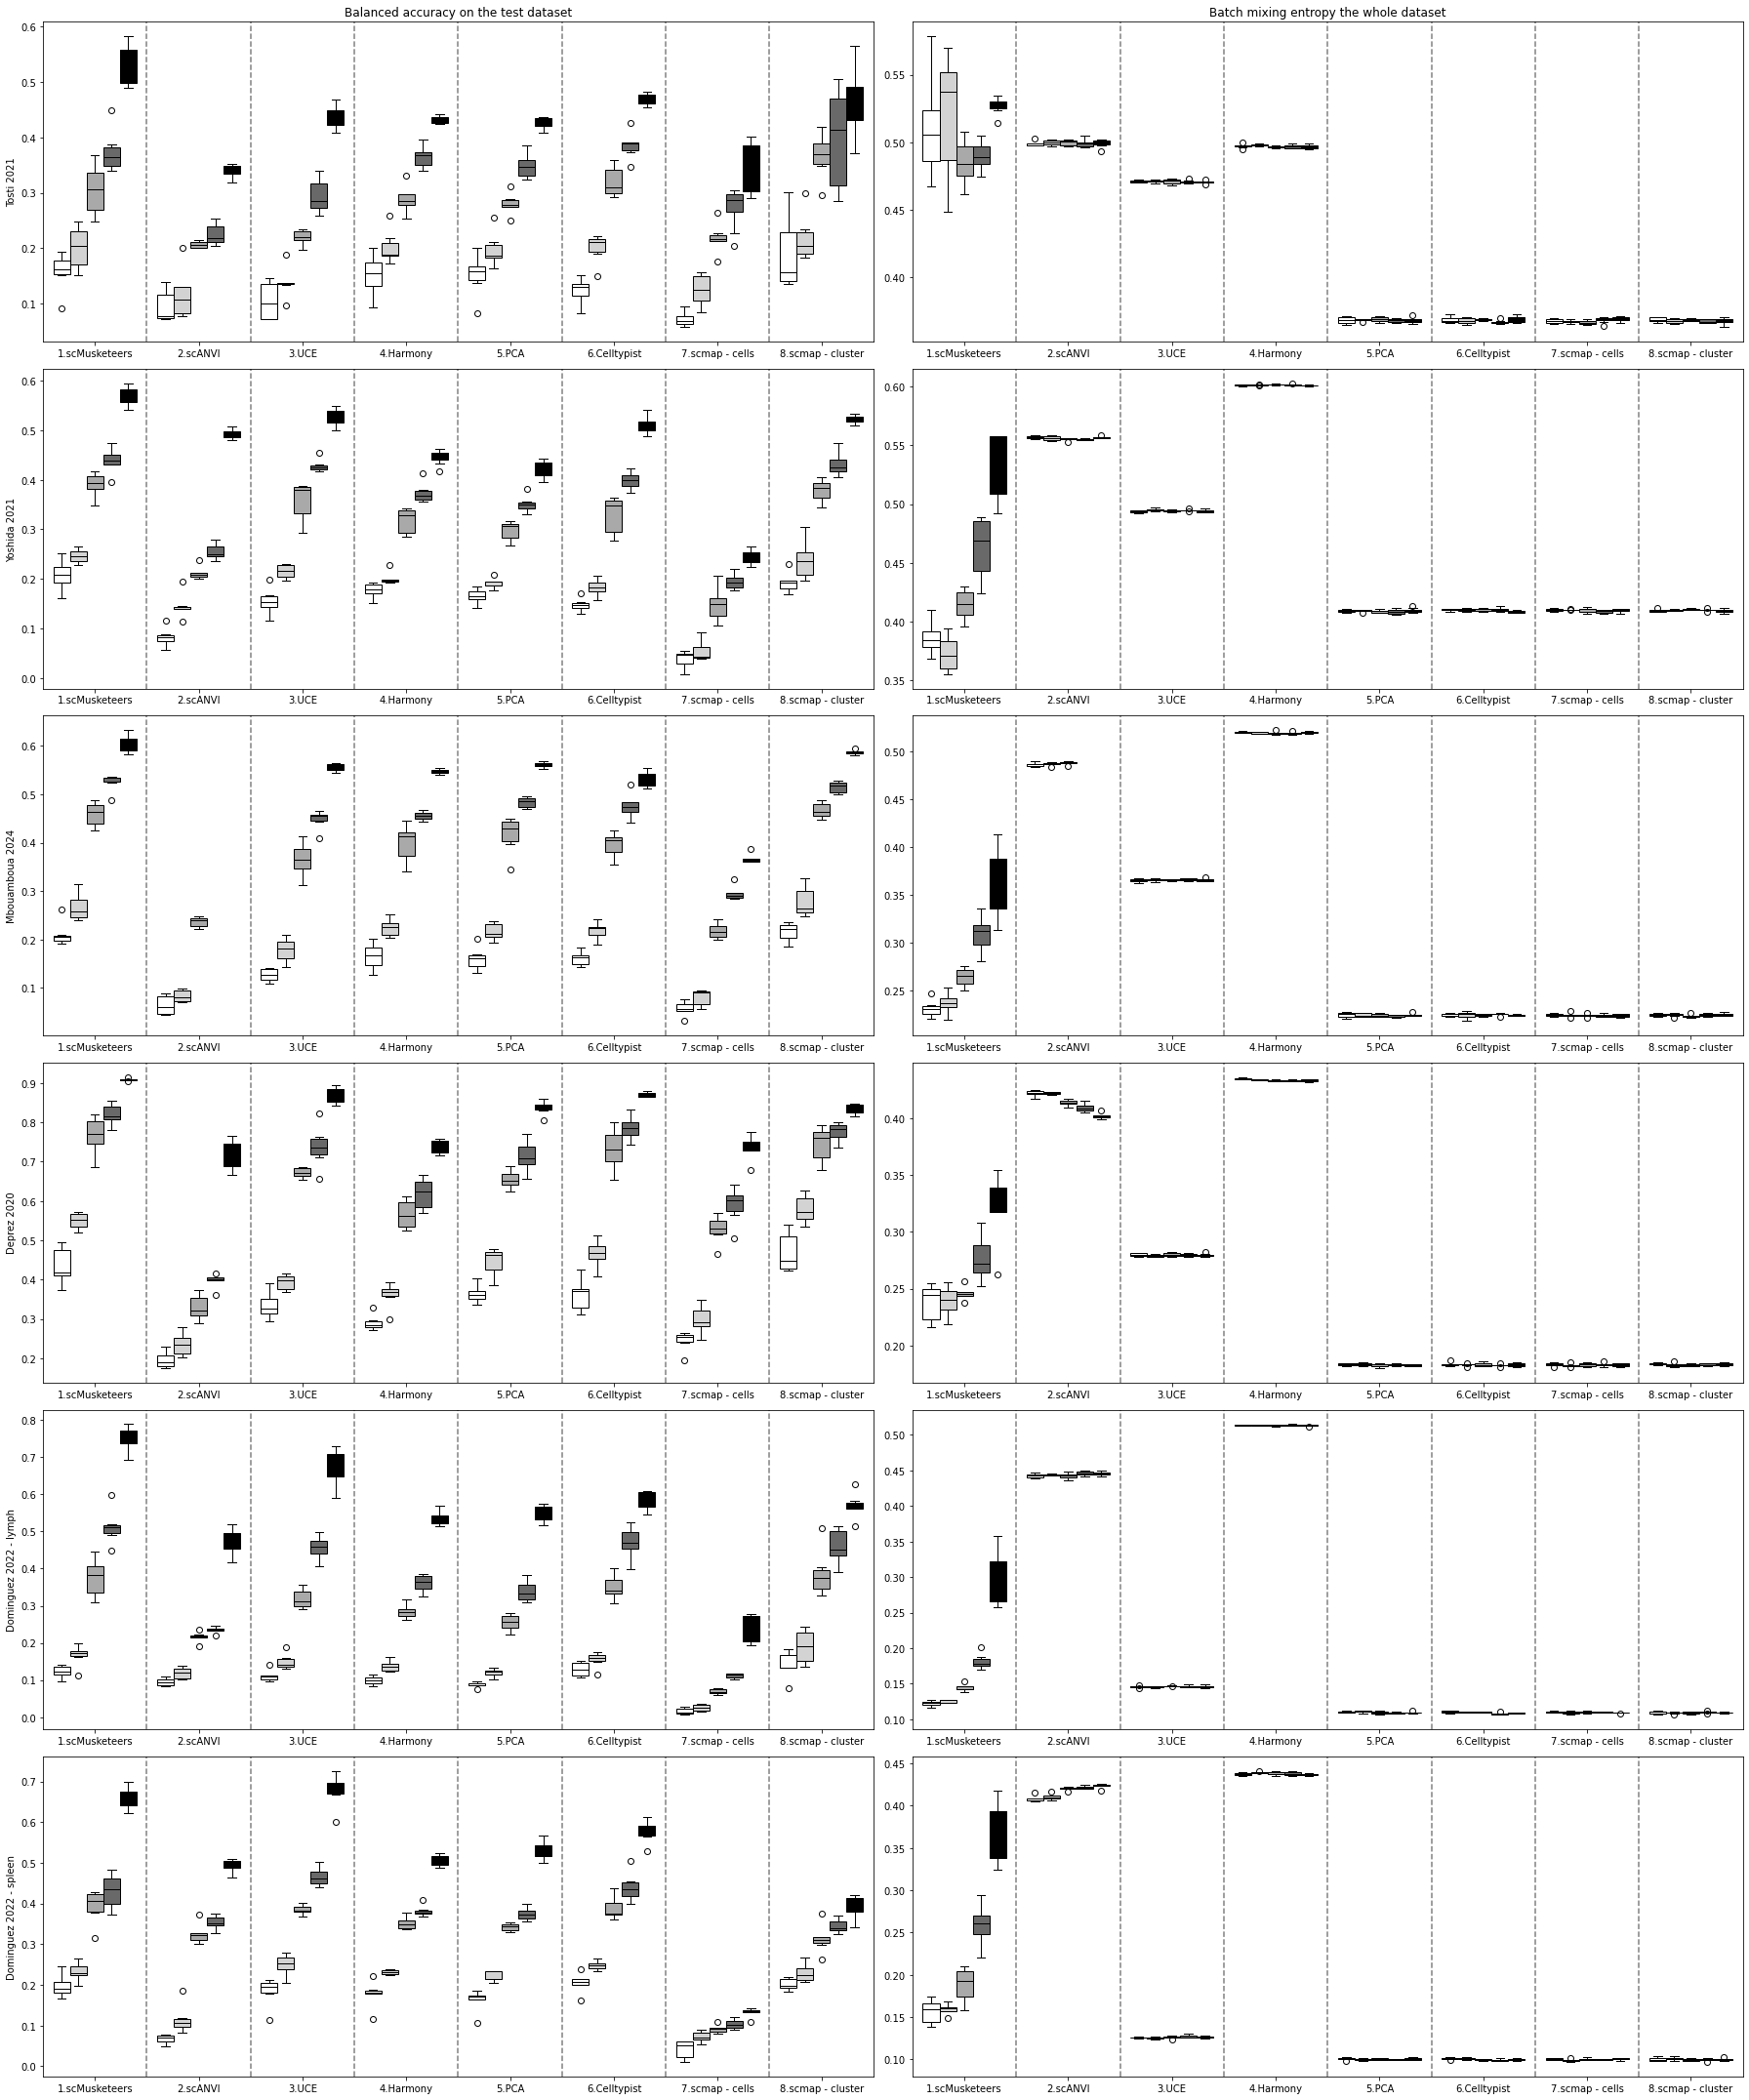

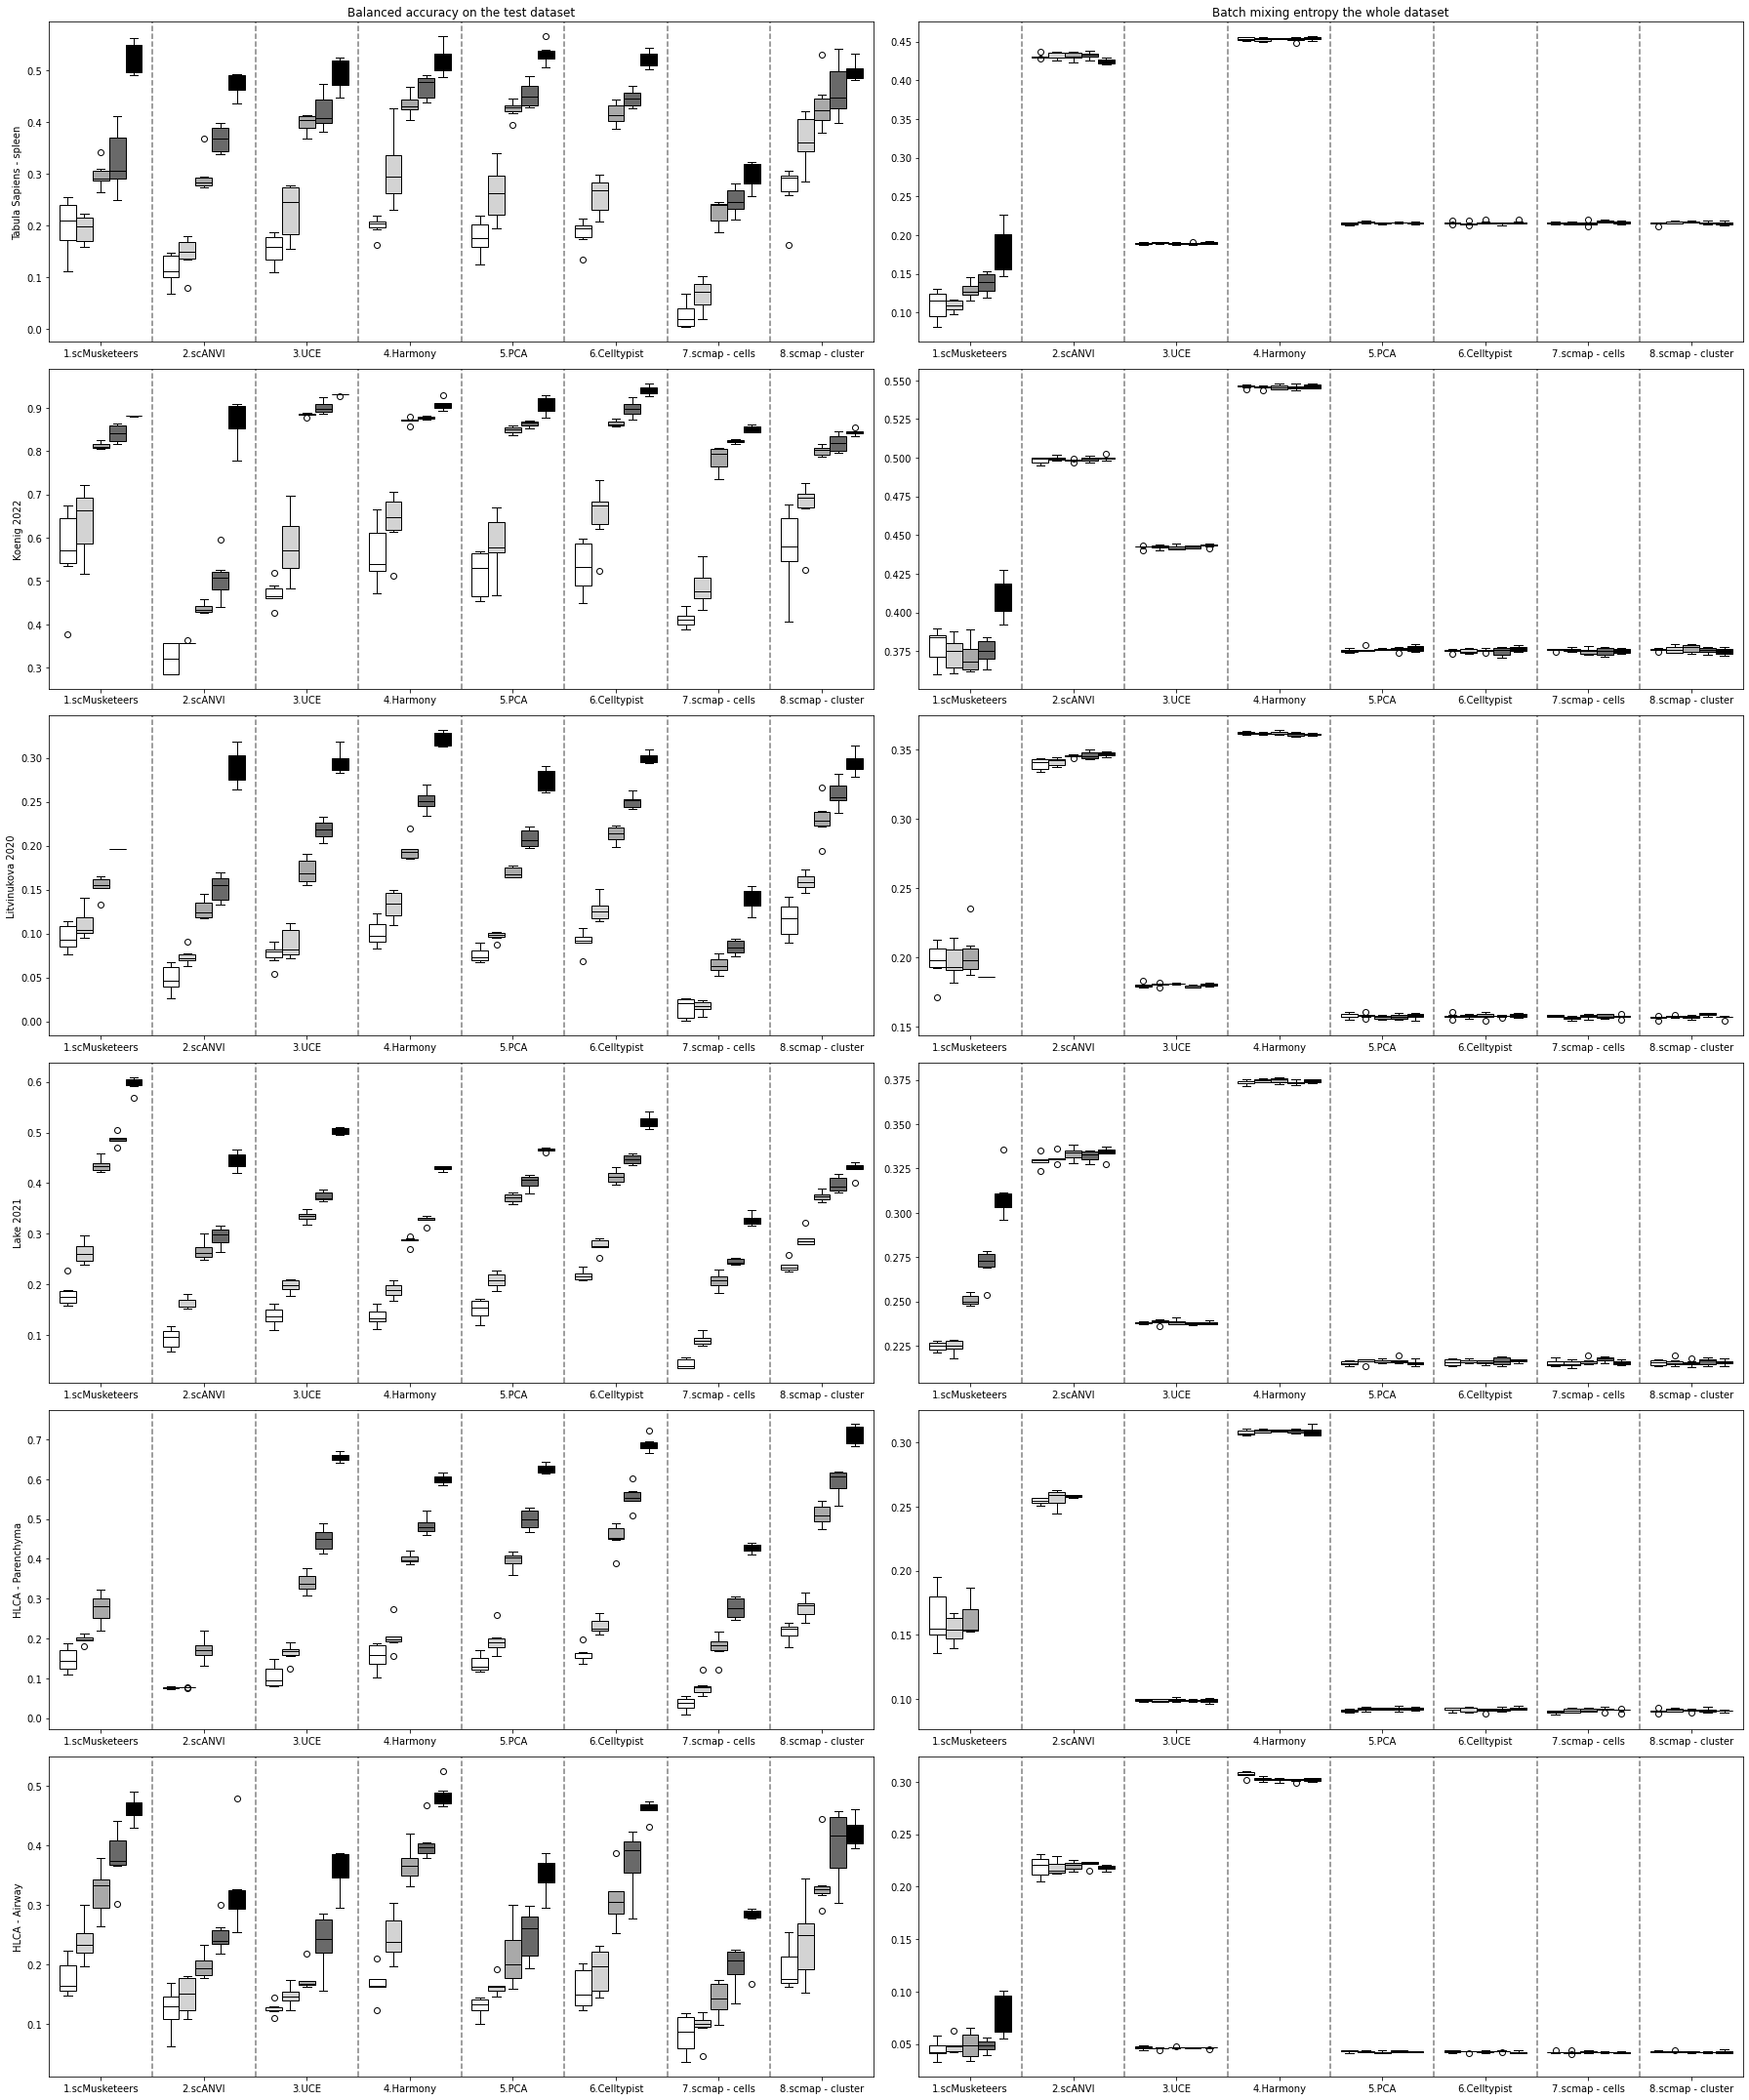

In [28]:
split = 'test'
met = 'balanced_acc'
# exclude_ds = ['tosti_2021', 'koenig_2022', 'litvinukova_2020','hlca_par_dataset_harmonized', 'hlca_trac_dataset_harmonized']
exclude_ds = []
show_legend = False
n_keep_colors = {'5':'white', '10':'lightgrey', '50':'darkgrey', '100': 'dimgrey', '500':'black'}

for diff in diff_dict:
    if diff != 'dataset':
        print(f'--------- {diff} ---------')
        n_lines = max(len([ i for i in diff_dict[diff] if i not in exclude_ds]),2)
        f, axes = plt.subplots(n_lines, 2, figsize = (25,5*n_lines))
        i=0
        for dataset_name in diff_dict[diff]:
            if dataset_name not in exclude_ds:
                
                task_3 = runs_table_df.query("task == 'task_3'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}")
                
                task_3['dataset_name'] =task_3['dataset_name'].replace(aestetic_data_name)
                task_3['model'] =task_3['model'].replace(aestetic_model_name)
        
                # task_3['model'] = pd.Categorical(task_3['model'], ['scPermut', 'scanvi', 'uce', 'pca_svm', 'harmony_svm', 'celltypist', 'scmap_cells', 'scmap_cluster']) 
                bplot1 = axes[i,0]
                bplot2 = axes[i,1]

                sns.boxplot(x = 'model' ,y =f'{split}_{met}', hue = 'n_keep', order = colors.keys(),
                            hue_order = [5,10,50,100,500] , data = task_3, ax = bplot1, palette = sns.color_palette(n_keep_colors.values()))

                for j in range(1, len(task_3['model'].unique())):
                    bplot1.axvline(x=j - 0.5, color='gray', linestyle='dashed', linewidth=1.5)
                    
                bplot1.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot1.set_title('Balanced accuracy on the test dataset')
                if i != n_lines:
                    bplot1.set_xlabel('')
                if i == n_lines:
                    bplot1.set_xlabel('Model')
                bplot1.set_ylabel(f'{aestetic_data_name[dataset_name]}') # - {diff} setup')

                task_3['model'] = task_3['model'].replace({'Celltypist': 'PCA',
                           'scmap - cells': 'PCA',
                           'scmap - cluster': 'PCA'})
                colors_BE = {k:v for k, v in colors.items() if k not in ['Celltypist','scmap - cells','scmap - cluster']}
                
                sns.boxplot(x = 'model',y =f'full_batch_mixing_entropy', hue = 'n_keep',
                            order = colors_BE.keys(), hue_order = [5,10,50,100,500], 
                            data = task_3, ax = bplot2, palette = sns.color_palette(n_keep_colors.values()))

                for j in range(1, len(task_3['model'].unique())):
                    bplot2.axvline(x=j - 0.5, color='gray', linestyle='dashed', linewidth=1.5)
                
                bplot2.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot2.set_title('Batch mixing entropy the whole dataset')
                if i != n_lines:
                    bplot2.set_xlabel('')
                if i == n_lines:
                    bplot2.set_xlabel('Model')
                bplot2.set_ylabel('')

                
                if not show_legend: 
                    bplot1.get_legend().set_visible(False)
                    bplot2.get_legend().set_visible(False)
                    
                # f.suptitle(f'{dataset_name} - {diff} setup')
                i+=1
                # f.savefig(f'{fig_dir}task_3/prediction_boxplot_{diff}_BW.png', transparent=False)
                
                plt.tight_layout()

## hue = model (NOT IN PAPER)

In [ ]:
split = 'test'
met = 'balanced_acc'
# exclude_ds = ['tosti_2021', 'koenig_2022', 'litvinukova_2020','hlca_par_dataset_harmonized', 'hlca_trac_dataset_harmonized']
exclude_ds = []
show_legend = False

for diff in diff_dict:
    if diff != 'dataset':
        print(f'--------- {diff} ---------')
        n_lines = max(len([ i for i in diff_dict[diff] if i not in exclude_ds]),2)
        f, axes = plt.subplots(n_lines, 2, figsize = (25,5*n_lines))
        i=0
        for dataset_name in diff_dict[diff]:
            if dataset_name not in exclude_ds:
                
                task_3 = runs_table_df.query("task == 'task_3'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}")
                
                task_3['dataset_name'] =task_3['dataset_name'].replace(aestetic_data_name)
                task_3['model'] =task_3['model'].replace(aestetic_model_name)
        
                # task_3['model'] = pd.Categorical(task_3['model'], ['scPermut', 'scanvi', 'uce', 'pca_svm', 'harmony_svm', 'celltypist', 'scmap_cells', 'scmap_cluster']) 
                bplot1 = axes[i,0]
                bplot2 = axes[i,1]

                sns.boxplot(x = 'n_keep',y =f'{split}_{met}', hue = 'model', order = [5,10,50,100,500], hue_order = colors.keys(), data = task_3, ax = bplot1, palette = sns.color_palette(colors.values()))
                bplot1.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot1.set_title('Balanced accuracy on the test dataset')
                if i != n_lines:
                    bplot1.set_xlabel('')
                if i == n_lines:
                    bplot1.set_xlabel('Model')
                bplot1.set_ylabel(f'{aestetic_data_name[dataset_name]}') # - {diff} setup')

                task_3['model'] = task_3['model'].replace({'Celltypist': 'PCA',
                           'scmap - cells': 'PCA',
                           'scmap - cluster': 'PCA'})
                colors_BE = {k:v for k, v in colors.items() if k not in ['Celltypist','scmap - cells','scmap - cluster']}
                
                sns.boxplot(x = 'n_keep',y =f'full_batch_mixing_entropy', hue = 'model', order = [5,10,50,100,500], hue_order = colors_BE.keys(), data = task_3, ax = bplot2, palette = sns.color_palette(colors_BE.values()))
                bplot2.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot2.set_title('Batch mixing entropy the whole dataset')
                if i != n_lines:
                    bplot2.set_xlabel('')
                if i == n_lines:
                    bplot2.set_xlabel('Model')
                bplot2.set_ylabel('')

                
                if not show_legend: 
                    bplot1.get_legend().set_visible(False)
                    bplot2.get_legend().set_visible(False)
                    
                # f.suptitle(f'{dataset_name} - {diff} setup')
                i+=1
                f.savefig(f'{fig_dir}task_3/prediction_boxplot_{diff}.png', transparent=False)
                
                plt.tight_layout()

--------- all12 ---------
--------- tosti_2021 ---------
--------- yoshida_2021 ---------
--------- htap ---------
--------- ajrccm_by_batch ---------
--------- dominguez_2022_lymph ---------
--------- dominguez_2022_spleen ---------
--------- all22 ---------
--------- tabula_2022_spleen ---------
--------- koenig_2022 ---------
--------- litvinukova_2020 ---------
--------- lake_2021 ---------
--------- hlca_par_dataset_harmonized ---------
--------- hlca_trac_dataset_harmonized ---------


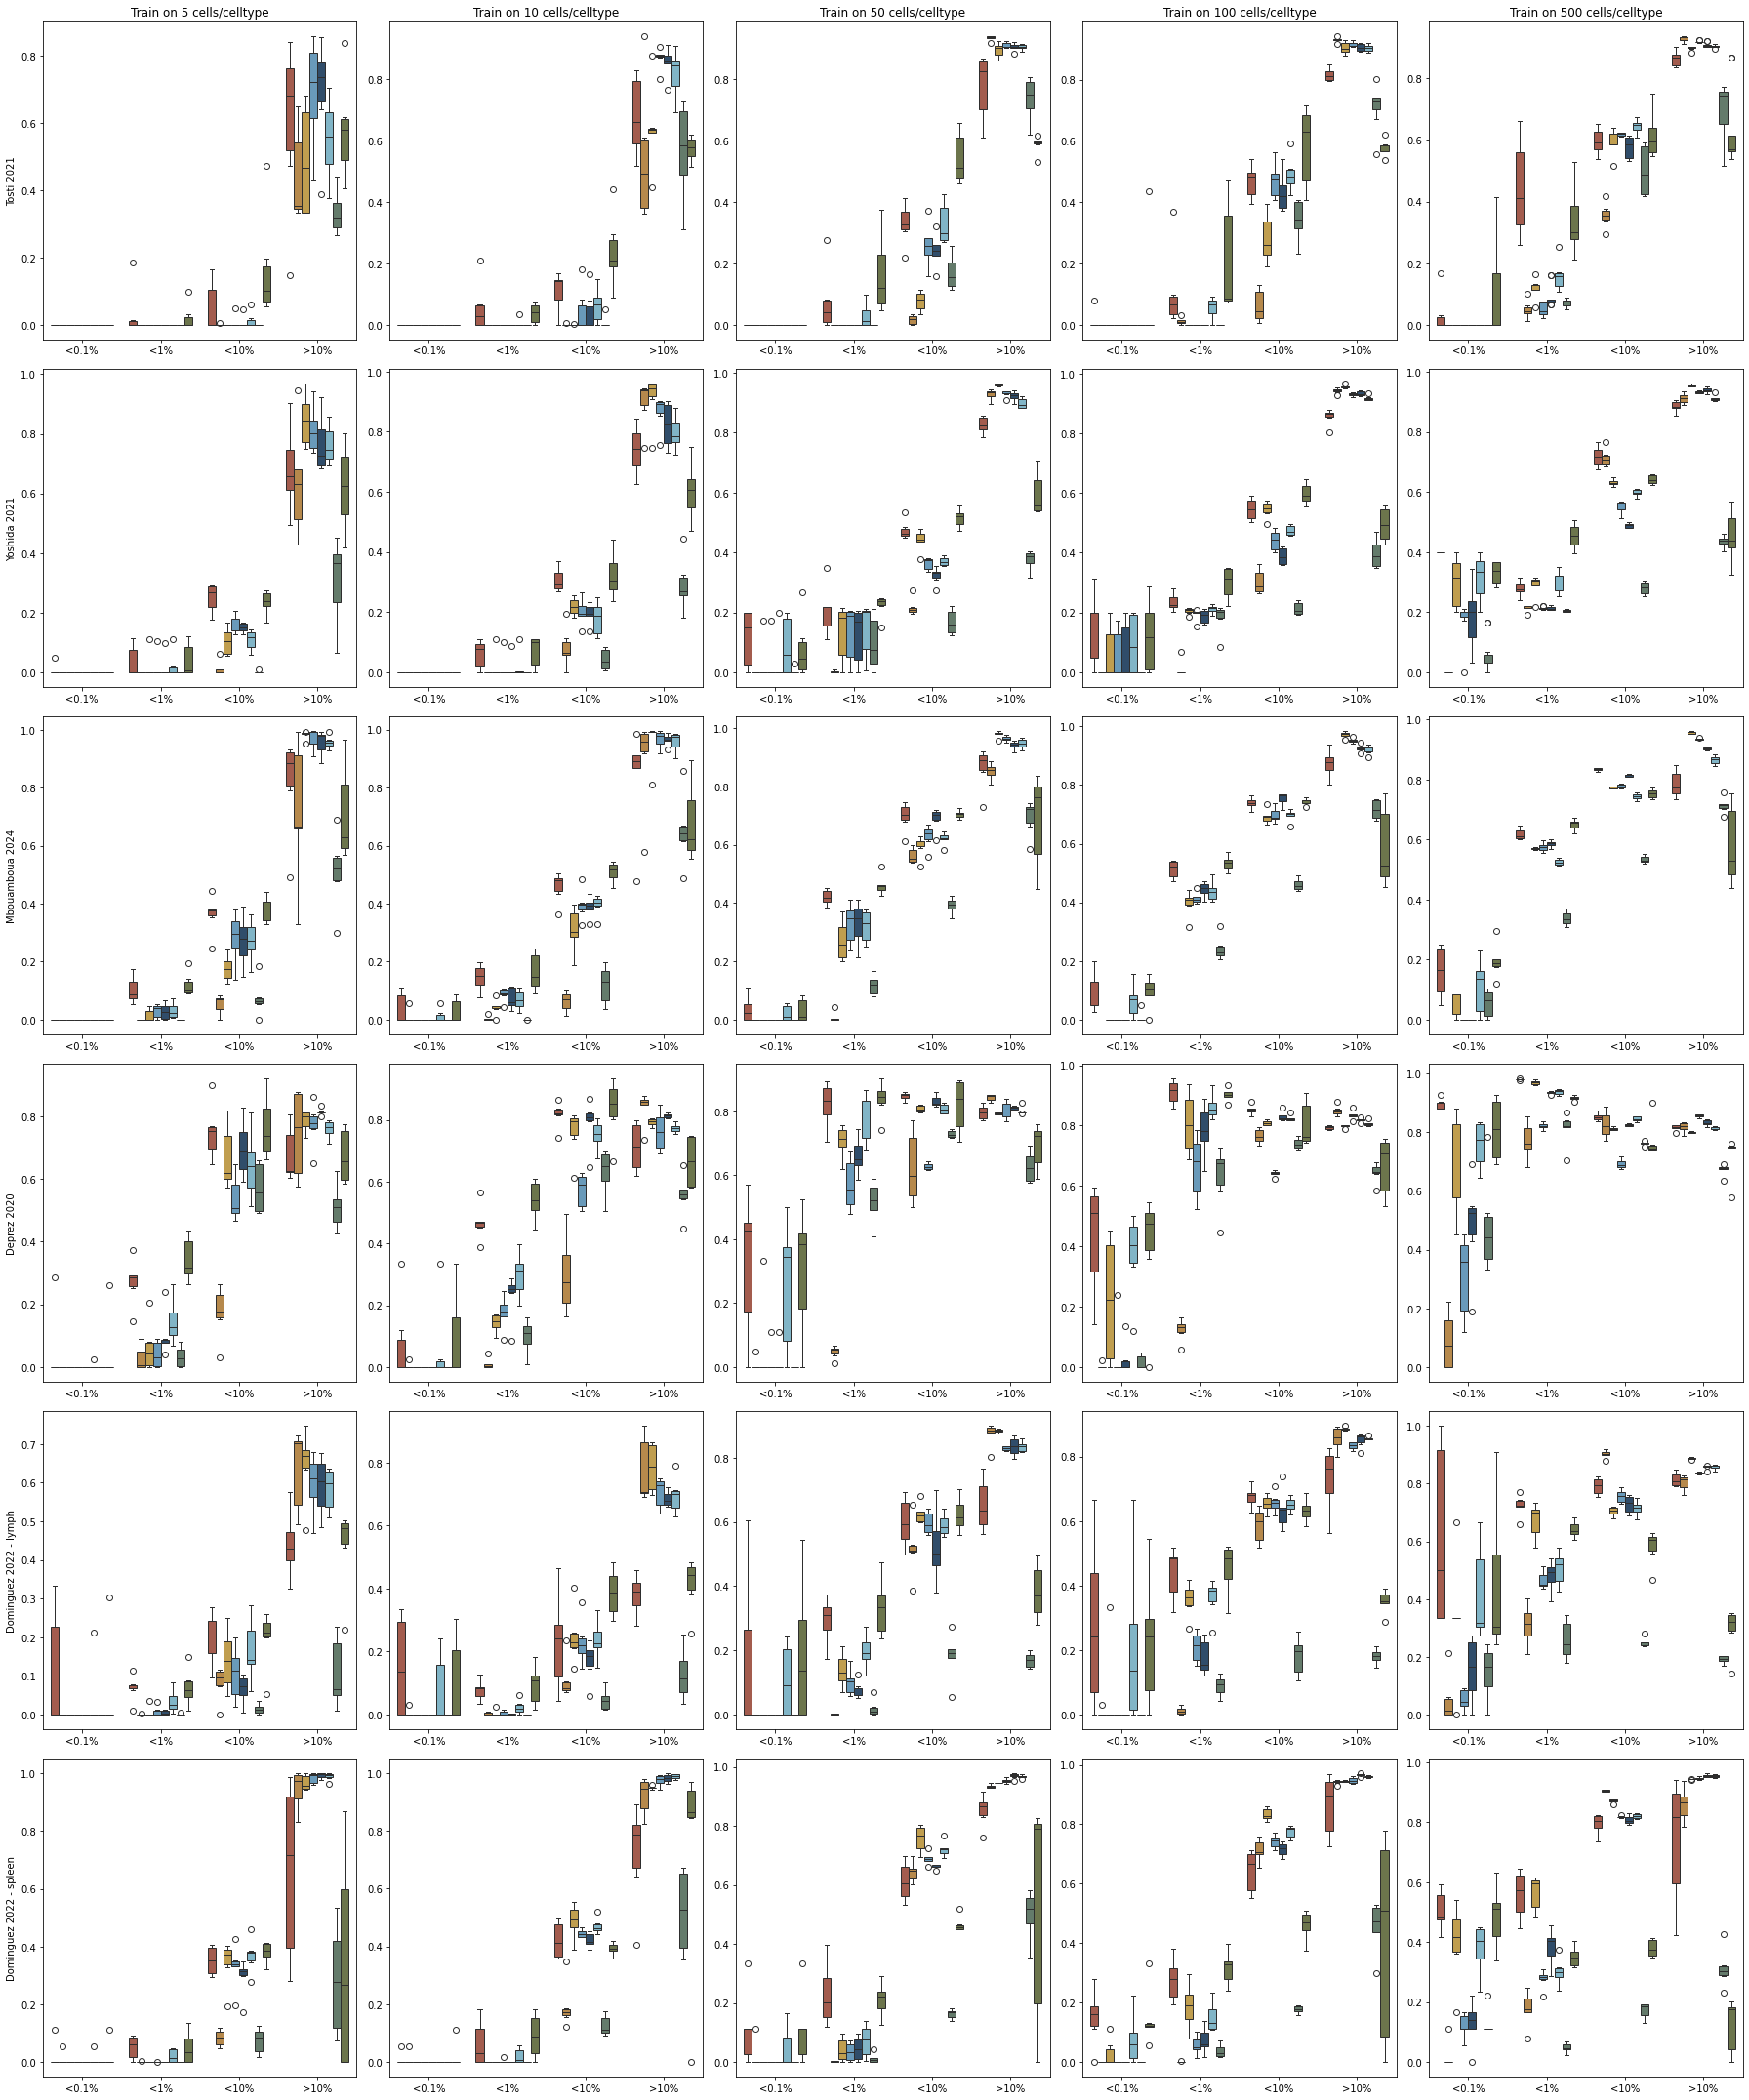

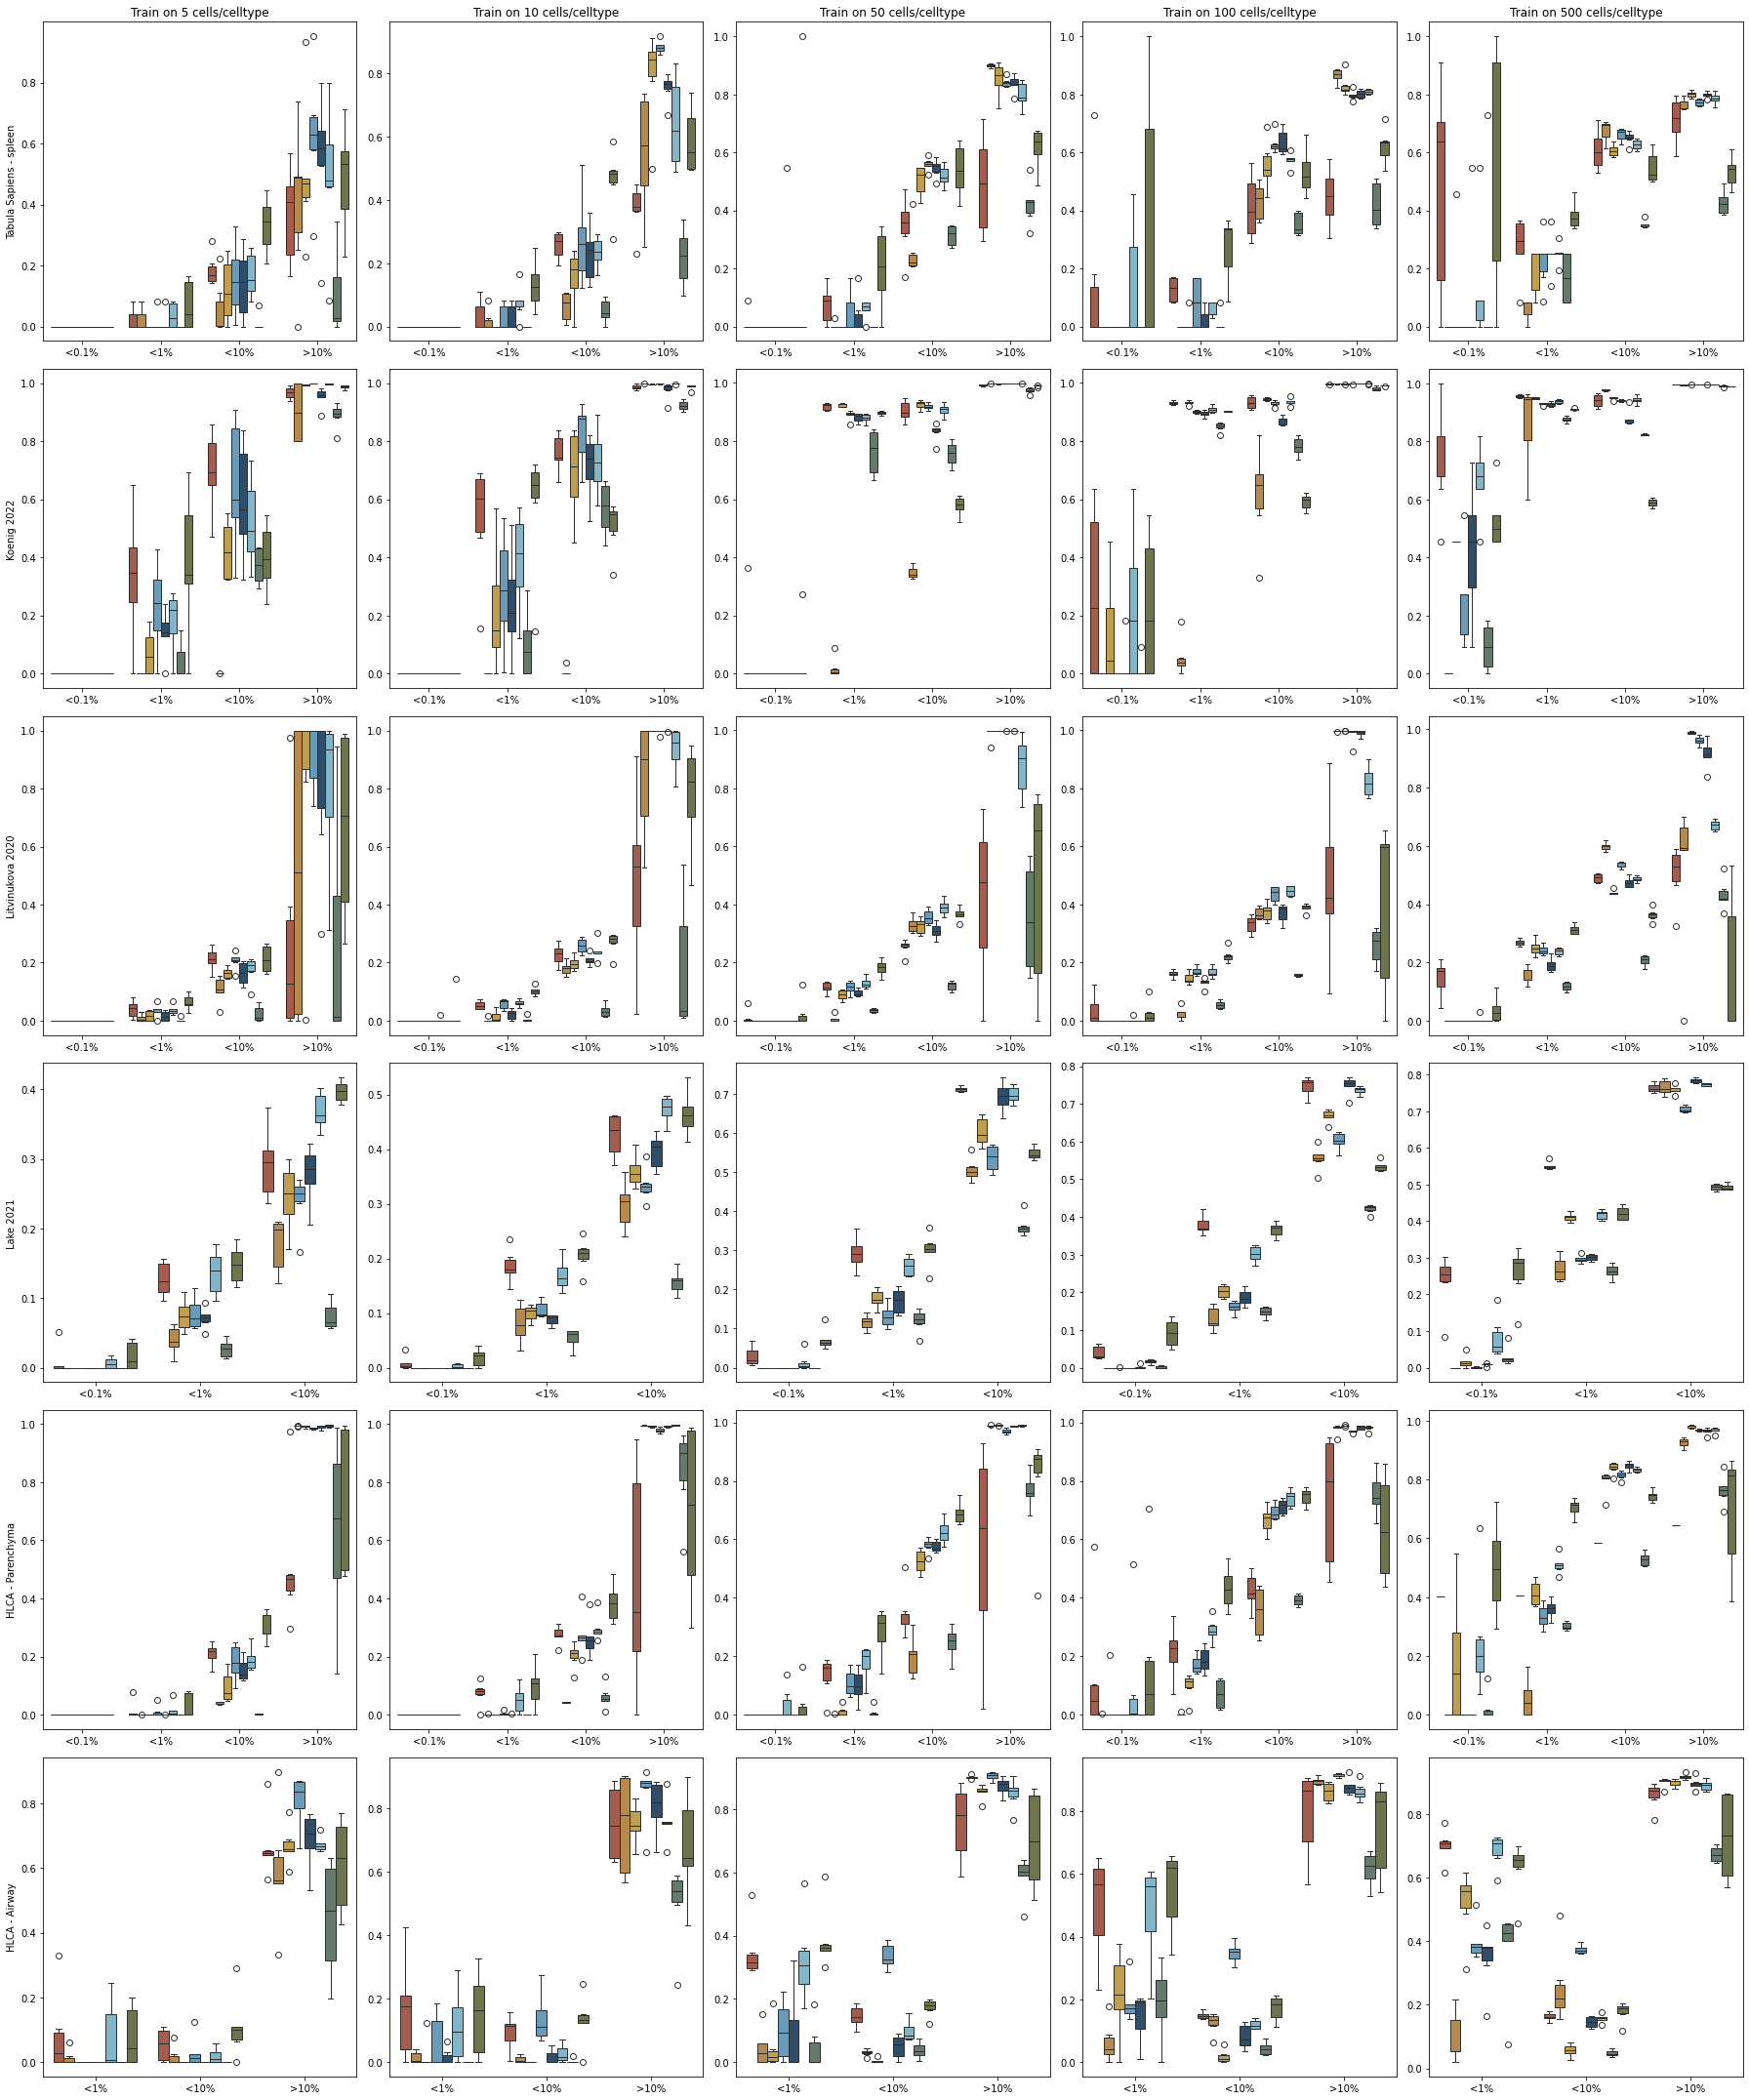

In [40]:
split = 'test'
met = 'balanced_acc'
# exclude_ds = ['tosti_2021', 'koenig_2022', 'litvinukova_2020','hlca_par_dataset_harmonized', 'hlca_trac_dataset_harmonized']
exclude_ds = []
ds = [i for v in diff_dict.values() for i in v]


show_legend = False

for diff in diff_dict:
    if diff != 'dataset':
        print(f'--------- {diff} ---------')
        n_lines = max(len([ i for i in diff_dict[diff] if i not in exclude_ds]),2)
        f, axes = plt.subplots(n_lines, 5, figsize = (25,5*n_lines))
        i=0
            
        for dataset_name in diff_dict[diff]:
            if dataset_name not in exclude_ds:
                print(f'--------- {dataset_name} ---------')

                for j,n_keep in enumerate([5,10,50,100,500]):
                    bplot1 = axes[i,j]
                    
                    task_3 = runs_table_df.query("task == 'task_3'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}").query(f'n_keep == {n_keep}')
            
                    task_3['dataset_name'] =task_3['dataset_name'].replace(aestetic_data_name)
                    task_3['model'] =task_3['model'].replace(aestetic_model_name)
                    
                    sub =task_3[['model', 'test_fold_nb',f'{split}_balanced_acc', f'{split}_xxsmall_balanced_acc',f'{split}_small_balanced_acc', f'{split}_medium_balanced_acc', f'{split}_large_balanced_acc']]
                    sub = pd.melt(sub, id_vars = 'model', value_vars = [f'{split}_xxsmall_balanced_acc',f'{split}_small_balanced_acc', f'{split}_medium_balanced_acc', f'{split}_large_balanced_acc'])
                    sub = sub.replace({f'{split}_xxsmall_balanced_acc' : '<0.1%',f'{split}_small_balanced_acc':'<1%', f'{split}_medium_balanced_acc':'<10%',f'{split}_large_balanced_acc':'>10%'})
            
                    if dataset_name in ['tran_2021',aestetic_data_name['tran_2021'], 'hlca_trac_dataset_harmonized', aestetic_data_name['hlca_trac_dataset_harmonized']]:
                            ord =  ['<1%','<10%','>10%']
                    elif dataset_name in ['lake_2021', aestetic_data_name['lake_2021']]:
                        ord =  ['<0.1%','<1%','<10%']
                    else :
                        ord = ['<0.1%','<1%','<10%','>10%']
                                
                    sns.boxplot(x='variable',y ='value',hue = 'model',order = ord, hue_order = colors.keys(), data = sub,ax = bplot1, palette = sns.color_palette(colors.values()))
                    bplot1.tick_params(axis='x', rotation=0)
                    bplot1.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

                    if j == 0:
                        bplot1.set_ylabel(aestetic_data_name[dataset_name])
                    else : 
                        bplot1.set_ylabel('')
                    if i == 0:
                        bplot1.set_title(f'Train on {n_keep} cells/celltype')
                        
                    if i != n_lines:
                        bplot1.set_xlabel('')
                    if i == n_lines:
                        bplot1.set_xlabel('Celltype size')
            
                    if not show_legend: 
                        bplot1.get_legend().set_visible(False)
                    
                i += 1
            plt.tight_layout()
            f.savefig(f'{fig_dir}task_3/by_size/prediction_boxplot_by_size_{diff}.png', transparent=False)


# Figure 5 - Outperformance heatmap

In [10]:
runs_table_df = load_run_df()

https://app.neptune.ai/becavin-lab/benchmark/
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/becavin-lab/benchmark/metadata


In [31]:
def est_croissante(liste):
    return all(liste[i] < liste[i + 1] for i in range(len(liste) - 1))


In [12]:
ds = [i for v in diff_dict.values() for i in v]

In [34]:
split = 'test'
met = 'balanced_acc'

ds = [i for v in diff_dict.values() for i in v if i not in ['tran_2021']]

compare = pd.DataFrame(index = ds, columns = [i for i in aestetic_model_name.keys() if i not in ['scPermut', 'scPermut_default']])

for dataset_name in ds:
    print(f'--------- {dataset_name} ---------')
    task_3 = runs_table_df.query("task == 'task_3'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}")

    mean_acc = pd.pivot_table(task_3, values=f'{split}_{met}', index='model', columns='n_keep', aggfunc='mean')
    outperf = pd.Series(index=mean_acc.index).drop('scPermut')

    for model in outperf.index:
        best_acc = mean_acc.loc[model,500]
        scperm_acc = mean_acc.loc['scPermut',:] > best_acc
        if scperm_acc.any():
            outperf.loc[model] = scperm_acc[scperm_acc].index[0]
        else :
            outperf.loc[model] = 1000
        compare.loc[dataset_name,:] = outperf
compare = compare.astype(float)

--------- tosti_2021 ---------
--------- yoshida_2021 ---------


/tmp/ipykernel_242180/1383561173.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')
/tmp/ipykernel_242180/1383561173.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')
/tmp/ipykernel_242180/1383561173.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


--------- htap ---------
--------- ajrccm_by_batch ---------


/tmp/ipykernel_242180/1383561173.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')
/tmp/ipykernel_242180/1383561173.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


--------- dominguez_2022_lymph ---------
--------- dominguez_2022_spleen ---------


/tmp/ipykernel_242180/1383561173.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')
/tmp/ipykernel_242180/1383561173.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


--------- tabula_2022_spleen ---------
--------- koenig_2022 ---------


/tmp/ipykernel_242180/1383561173.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')
/tmp/ipykernel_242180/1383561173.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


--------- litvinukova_2020 ---------
--------- lake_2021 ---------


/tmp/ipykernel_242180/1383561173.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


--------- hlca_par_dataset_harmonized ---------
--------- hlca_trac_dataset_harmonized ---------


/tmp/ipykernel_242180/1383561173.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')
/tmp/ipykernel_242180/1383561173.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


In [35]:
compare = compare.replace({5:6,10:5,50:4,100:3,500:2, 1000:1}).astype(int)

In [36]:
compare = compare.rename(columns = aestetic_model_name, index = aestetic_data_name)

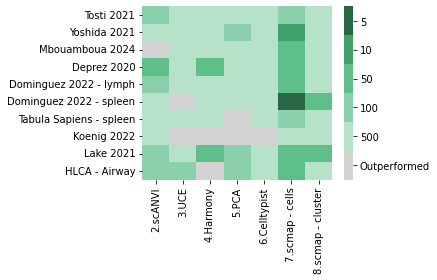

In [30]:
# colors = ["#296644","#3A9262", "#50B97F",  "#7CCB9F", "lightgray"]
# ticks = ["5%","10%","50%","90%",'Outperformed']

colors = ['lightgray',  "#B6E2CA", '#8AD0AA', '#5FBF8A', '#40A06B', '#296644',]
ticks = ['Outperformed', '500', '100', '50', '10', '5']
# colors = ["#04ff00","#28e525","#2ac327","#2aa328","lightgray"]
import matplotlib.colors as mcolors
import matplotlib as mpl

cmap = mcolors.LinearSegmentedColormap.from_list("my_palette", colors)
cmap = mpl.colors.ListedColormap(colors)
vmap = {i: v for i,v in enumerate(ticks)}
n = len(vmap)

ax = sns.heatmap(compare, cmap = cmap) # 1-compare is a trick to have the bar in the correct order

colorbar = ax.collections[0].colorbar
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(list(vmap.values()))
plt.tight_layout()
ax.get_figure().savefig(f'{fig_dir}task_3/comparison_heatmap.png', transparent=False,dpi = 100)


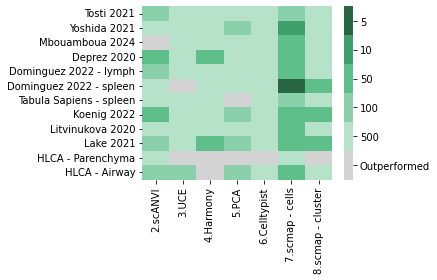

In [37]:
# colors = ["#296644","#3A9262", "#50B97F",  "#7CCB9F", "lightgray"]
# ticks = ["5%","10%","50%","90%",'Outperformed']

colors = ['lightgray',  "#B6E2CA", '#8AD0AA', '#5FBF8A', '#40A06B', '#296644',]
ticks = ['Outperformed', '500', '100', '50', '10', '5']
# colors = ["#04ff00","#28e525","#2ac327","#2aa328","lightgray"]
import matplotlib.colors as mcolors
import matplotlib as mpl

cmap = mcolors.LinearSegmentedColormap.from_list("my_palette", colors)
cmap = mpl.colors.ListedColormap(colors)
vmap = {i: v for i,v in enumerate(ticks)}
n = len(vmap)

ax = sns.heatmap(compare, cmap = cmap) # 1-compare is a trick to have the bar in the correct order

colorbar = ax.collections[0].colorbar
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(list(vmap.values()))
plt.tight_layout()
ax.get_figure().savefig(f'{fig_dir}task_3/comparison_heatmap.png', transparent=False,dpi = 100)
